In [1]:
import networkx as nx;
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
import scipy;
from ipywidgets import *

## Creating the graph

Here we read the links and the node positions in the layout from input files. The node positions are not too important, we use them just to ensure that the layout looks the same as on the sheets handed out.

In [2]:
links_file, node_pos_file = 'random_walk_graph.tsv','random_walk_graph_pos.tsv';

In [3]:
pd.read_csv(links_file,sep = '\t')

,source,target
0,0,1
1,1,2
2,1,3
3,1,4
4,1,5
5,3,4
6,3,5
7,4,5
8,5,6


We read the list of links and create a graph using Networkx.

In [4]:
link_list_df = pd.read_csv(links_file, sep = '\t');
graph = nx.Graph();
for i in range(0,len(link_list_df)):
    graph.add_edge(link_list_df['source'][i],link_list_df['target'][i]);

These are the node positions in the layout.

In [5]:
pd.read_csv(node_pos_file, sep = '\t')

,node,x_pos,y_pos
0,0,-0.300000,0.600000
1,1,-0.205629,0.099484
2,2,-0.750000,0.150000
3,3,0.126781,-0.411355
4,4,-0.138489,-0.320409
5,5,0.369719,-0.123090
6,6,0.800000,0.100000


In [6]:
node_pos_df = pd.read_csv(node_pos_file, sep = '\t');
node_pos_dict = {};
for i in range(0,len(node_pos_df)):
    node_pos_dict[int(node_pos_df['node'][i])] = [float(node_pos_df['x_pos'][i]),float(node_pos_df['y_pos'][i])];

In the next cell we prepare the layout using the node positions obtained above, and we also export it to a png file.

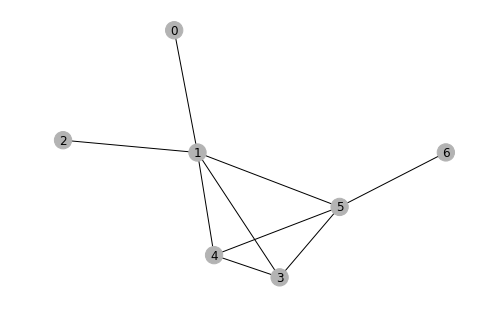

In [7]:
node_labels = {node: str(node) for node in graph.nodes()};
layout_file = 'rw_graph_layout.png';
nx.draw(graph, pos = node_pos_dict,labels = node_labels,node_color=[(0.7,0.7,0.7,1.0)]*graph.number_of_nodes())
plt.savefig(layout_file,dpi = 300)

## Plotting the empirical node visit frequencies

The 5 teams "simulate" a random walk on the spread sheet, and in this section we are going to plot the recorded empirical node visit frequencies. First we just define lists corresponding to the visited node sequences, and then we prepare histograms using Pyplot. 

In [8]:
team_A_ns = [0,1,4,3,5,3,4,5,6,5,3];
team_B_ns = [1,3,1,5,6,5,3,1,0,1,4,1,3,4,3,1,3,4,1,4,1,5];
team_C_ns = [3,5,6,5,3,4,1,0,1,0,1,3,1,5,3,4,1,4,1,2];
team_D_ns = [3,5,4,3,1,0,1,5,6,5,6,5,4,3,4];
team_E_ns = [4,1,4,5,3,4,3,4,3,5,6];

We need bins when preparing a histogram. In the current problem the natural choice is to have just a single node per bin, and since nodes are indexed by integers starting from 0, we define the bin boundaries as [-0.5,0.5,1.5,...]

In [9]:
bins = np.arange(-0.5,max([node for node in graph.nodes()])+1.5,1.0);

Everything is set, let's plot histograms.

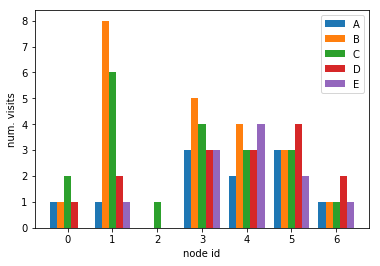

In [10]:
plt.clf();
merge = [team_A_ns,team_B_ns,team_C_ns,team_D_ns,team_E_ns];
plt.hist(merge,bins=bins, histtype='bar',label = ['A','B','C','D','E']);
plt.xlabel('node id')
plt.ylabel('num. visits')
plt.legend(loc = 'upper right')
plt.show();

In our first histogram we did not take into account that the node visit sequences were not of equal length. We can correct this by preparing normed histograms. (Inside the pyplot.hist function we declare 'density = True').

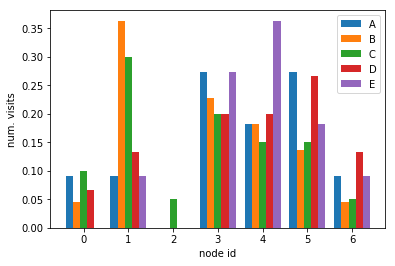

In [11]:
plt.clf();
merge = [team_A_ns,team_B_ns,team_C_ns,team_D_ns,team_E_ns];
plt.hist(merge,bins=bins, histtype='bar',label = ['A','B','C','D','E'],density = True);
plt.xlabel('node id')
plt.ylabel('num. visits')
plt.legend(loc = 'upper right')
plt.show();

To obtain a better estimate on the average node visit frequencies for long random walks we can simply 'add' (concatenate) the individual walks performed by the 4 teams.

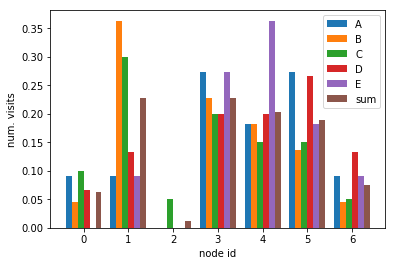

In [12]:
plt.clf();
merge = [team_A_ns,team_B_ns,team_C_ns,team_D_ns,team_E_ns,team_A_ns + team_B_ns + team_C_ns + team_D_ns + team_E_ns]
plt.hist(merge,bins=bins, histtype='bar',label = ['A','B','C','D','E','sum'], density= True)
plt.xlabel('node id')
plt.ylabel('num. visits')
plt.legend(loc = 'upper right');
plt.show();

## Simulating the random walk

Instead of performing the random walk with dice throwing we can write a small function that can simulate the random walk up to any desired number of steps.

In [13]:
def Random_walk(graph,max_num_steps):
    _walker_pos = [];
    _walker_pos.clear();
    _current_pos = np.random.choice(graph.nodes());
    for i in range(0,max_num_steps):
        _walker_pos.append(_current_pos);
        _current_pos = np.random.choice(list(graph.neighbors(_current_pos)));
    _walker_pos.append(_current_pos);
    return _walker_pos;    

In [14]:
walker_pos = Random_walk(graph,50);

Let's make an interactive visualisation of the random walking.

In [15]:
def Plot_nets(graph,pos_vec,color_dict,step):
    _color_list = color_dict[step];
    nx.draw_networkx(graph,pos=pos_vec,node_color=_color_list);
    plt.show();

In [16]:
node_num_vis_step = {0: {node: 0 for node in graph.nodes()}};
node_num_vis_step[0][walker_pos[0]] = 1;
for i in range(1,len(walker_pos)):
    node_num_vis_step[i] = dict(node_num_vis_step[i-1]);
    node_num_vis_step[i][walker_pos[i]] += 1;

In [17]:
max_vis = max( [max(node_num_vis_step[step].values()) for step in node_num_vis_step]);
rw_colors = {};
rw_colors.clear();
for step in node_num_vis_step:
    rw_colors[step] = [plt.cm.coolwarm(node_num_vis_step[step][node]/max_vis) for node in node_num_vis_step[step]];
    cur_node = walker_pos[step];
    cur_id = [node for node in node_num_vis_step[step]].index(cur_node);
    rw_colors[step][cur_id] = (0.0,1.0,0.0,1.0); # green

In [18]:
interact(Plot_nets,graph = fixed(graph), pos_vec=fixed(node_pos_dict),color_dict=fixed(rw_colors),
         step = IntSlider(min = 0, max = len(rw_colors)-1, step = 1, value =0,
                                            description = "step"))

interactive(children=(IntSlider(value=0, description='step', max=50), Output()), _dom_classes=('widget-interac…

<function __main__.Plot_nets(graph, pos_vec, color_dict, step)>

It is time to compare the simulations by the computer to the results obtained from dice throwing.

In [19]:
long_walker_pos = Random_walk(graph,10000);

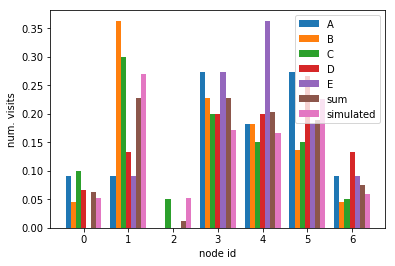

In [23]:
plt.clf();
merge = [team_A_ns,team_B_ns,team_C_ns,team_D_ns,team_E_ns,team_A_ns + team_B_ns + team_C_ns + team_D_ns + team_E_ns,long_walker_pos]
plt.hist(merge,bins=bins, histtype='bar',label = ['A','B','C','D','E','sum','simulated'], density= True)
plt.xlabel('node id')
plt.ylabel('num. visits')
plt.legend(loc = 'upper right');
plt.show();